In [ ]:
import numpy as np
import tensorflow as tf
from utils_functions import *
from plan import *
import random
from utils import *
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils  import plot_model
from tensorflow.keras.utils  import Sequence
import datetime, os
from matplotlib import pyplot as plt
import optuna



In [3]:
# controllo di star effettivamente usando la GPU

print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
print(tf.config.list_physical_devices('GPU'))
print("nome gpu: ",tf.test.gpu_device_name())

Num GPUs Available:  1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
nome gpu:  /device:GPU:0


### Caricamento dataset statici

In [ ]:
test=load_file("./Dataset/set_test")
train=load_file("./Dataset/set_training")
validation=load_file("./Dataset/set_validation")

test=np.array(test,dtype=np.int8)
train=np.array(train,dtype=np.int8)
validation=np.array(validation,dtype=np.int8)
 

## Modello

### Optuna 

In [ ]:

def objective(trial):
    input_dim=340
    num_hidden1=170
    ae = tf.keras.models.Sequential()
    l_rate=trial.suggest_float("learning rate", 2e-5, 5e-3, log=True)
    #reg=trial.suggest_float("reg param", 1e-7, 2e-5, log=True)
    code= trial.suggest_int('n_units_embedded', 50,60,log=True)
    b_1=trial.suggest_float("beta 1", 0.9, 0.99, step=0.01 )
    b_2=trial.suggest_float("beta 2", 0.9, 0.999,step= 0.01)

    optuna_dir= os.path.join("./optunaLogs/", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    
    ae.add(Input(shape=(input_dim,)))
    ae.add(tf.keras.layers.BatchNormalization())
    ae.add(tf.keras.layers.Dense(num_hidden1, activation='relu',kernel_initializer="he_uniform",))     
    ae.add(tf.keras.layers.BatchNormalization())
    ae.add(tf.keras.layers.Dense(code, activation='relu', kernel_initializer="he_uniform",name="embedding")) 
    ae.add(tf.keras.layers.BatchNormalization())
    ae.add(tf.keras.layers.Dense(num_hidden1, activation='relu',kernel_initializer="he_uniform",)) 
    ae.add(tf.keras.layers.BatchNormalization())
    ae.add(tf.keras.layers.Dense(input_dim, activation='sigmoid',kernel_initializer=tf.keras.initializers.GlorotUniform()))


    callback = [tf.keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True),
                tf.keras.callbacks.TensorBoard(log_dir=optuna_dir,histogram_freq=1, write_graph=True, write_images=True)
    
    
    ]
    ae.compile(optimizer=tf.keras.optimizers.Nadam(l_rate,b_1,b_2), loss='binary_crossentropy',metrics=["accuracy","Precision","Recall"])


    history=ae.fit(x=train,y=train, epochs=500,batch_size=5000, validation_data=(validation,validation),callbacks=callback)

    optuna_dir_saved_model=os.path.join(optuna_dir, str(trial.number))
    ae.save(optuna_dir_saved_model)

    return history.history["loss"][-1]

study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=15, timeout=None, gc_after_trial=True)

print("Number of finished trials: ", len(study.trials))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)

print("  Params: ")
for key, value in trial.params.items():
    print("    {}: {}".format(key, value))



### AutoEncoder Base

In [ ]:

logdir = os.path.join("./TestLogs/", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10,restore_best_weights=True),
    tf.keras.callbacks.TensorBoard(log_dir=logdir,histogram_freq=1, write_graph=True, write_images=True)
]

#tf.keras.regularizers.L1(l1=1e-4)
param={"INPUT_SIZE" : 340,
"HIDDEN_SIZE" : 170,
"HIDDEN_SIZE2" : None,
"HIDDEN_SIZE3" : None,
"CODE_SIZE" : 58,
"KERNEL_INIZIALIZER":"he_uniform",
"KERNEL_REGULIZER":None,
#tf.keras.regularizers.L2(l2=1e-5),
'BIAS_REGULARIZER': None,
"ACTIVATION":'relu',
"OPTIMIZER":tf.keras.optimizers.Nadam(learning_rate=0.0008,beta_1=0.83,beta_2=0.94),
#tf.keras.optimizers.Adam(learning_rate=0.00018,beta_1=0.87),
"EPOCHS":1000,
"BATCH_SIZE":5000,
"BATCH_NORMAIZATION": 4
}

autoencoder=tf.keras.models.Sequential()

autoencoder.add(Input(shape=(param["INPUT_SIZE"],)))
autoencoder.add(tf.keras.layers.BatchNormalization())
autoencoder.add( Dense(param["HIDDEN_SIZE"], activation=param["ACTIVATION"], kernel_initializer=param["KERNEL_INIZIALIZER"],kernel_regularizer=param["KERNEL_REGULIZER"], bias_regularizer=param["BIAS_REGULARIZER"] ))
autoencoder.add(tf.keras.layers.BatchNormalization())
autoencoder.add(Dense(param["CODE_SIZE"], activation=param["ACTIVATION"],kernel_initializer=param["KERNEL_INIZIALIZER"],kernel_regularizer=param["KERNEL_REGULIZER"],bias_regularizer=param["BIAS_REGULARIZER"],name="embedding"))
autoencoder.add(tf.keras.layers.BatchNormalization())
autoencoder.add(Dense(param["HIDDEN_SIZE"], activation=param["ACTIVATION"], kernel_initializer=param["KERNEL_INIZIALIZER"],kernel_regularizer=param["KERNEL_REGULIZER"], bias_regularizer=param["BIAS_REGULARIZER"] ))
autoencoder.add(tf.keras.layers.BatchNormalization())
autoencoder.add( Dense(param["INPUT_SIZE"], activation='sigmoid',kernel_initializer=tf.keras.initializers.GlorotUniform()))

autoencoder.compile(optimizer=param["OPTIMIZER"], loss=tf.losses.BinaryCrossentropy(),metrics=["accuracy","Precision","Recall"])
history=autoencoder.fit(x=train,y=train, epochs=param["EPOCHS"],batch_size=param["BATCH_SIZE"], validation_data=(validation,validation), 
                        callbacks=my_callbacks)
                   

### Print and Test ae

In [ ]:

plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title("Loss")
plt.show()
    
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='validation')
plt.legend()
plt.title("Accuracy")
plt.show()

plt.plot(history.history['precision'], label='train')
plt.plot(history.history['val_precision'], label='validation')
plt.legend()
plt.title("Precision")
plt.show()

plt.plot(history.history['recall'], label='train')
plt.plot(history.history['val_recall'], label='validation')
plt.legend()
plt.title("Recall")
plt.show()

In [4]:
#val_predictions = autoencoder.predict(validation)
test_predictions = autoencoder.predict(test)

7211/7211 [==============================] - 23s 3ms/step


Numero di vettori decodificati correttamente: 176077 su 230728 totali 
Rapporto: 76.314% 
Media num di errori per array: 0.412



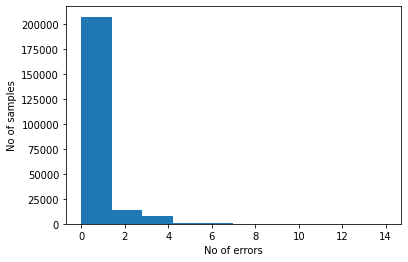

In [5]:
# Confronta prediction con test. Guardare in main.py per maggiori informazioni sul metodo
arr=results_info(test,test_predictions,logdir)

Salva modello

In [ ]:
#Se i risultati sono buoni salva il modello in modo che possa essere riusato

dir_model= os.path.join(logdir,"myModel")
autoencoder.save(dir_model)

autoencoder.summary()

Carica modello

In [6]:
#CARICA AUTOENCODER SALVATO

PATH_TO_LOAD=""
autoencoder = tf.keras.models.load_model(PATH_TO_LOAD)
autoencoder.summary()

In [ ]:
autoencoder.summary()

In [10]:
#%tensorboard --logdir logsTf
%load_ext tensorboard
#Avvio da terminale: spostarsi nella cartella dove è presente la cartella di log, > tensorboard --logdir nomecartella